In [0]:
%tensorflow_version 1.x
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

In [0]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [0]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [0]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [0]:
filelist_trainx = sorted(glob.glob('/content/drive/My Drive/input/dgu_trainx/*.jpg'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

# for i in range(len(filelist_trainx)):
# X_train = np.array([np.array(Image.open(fname)) for fname])


filelist_trainy = sorted(glob.glob('/content/drive/My Drive/input/dgu_trainy/*.jpg'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

In [0]:
def resizeX(filename, size = (256,192)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)

def resizeY(filename, size = (256,192)):
    im = Image.open(filename).convert('L')
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)
#   im_resized.save('/resized_ph2/X_train/X_img_'+str(i)+'.bmp', dpi = (192,256))

In [0]:
X_train_ph2_resized = []
Y_train_ph2_resized = []

for i in range(len(filelist_trainx)):
    X_train_ph2_resized.append(resizeX(filelist_trainx[i]))
    Y_train_ph2_resized.append(resizeY(filelist_trainy[i]))  

In [0]:
del(X_train)
del(Y_train)

X_train = np.array([np.array(img) for img in X_train_ph2_resized])
Y_train = np.array([np.array(img) for img in Y_train_ph2_resized])

(192, 256)


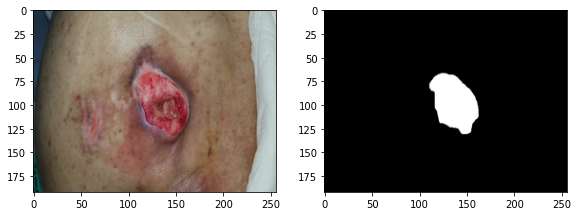

In [61]:
print(Y_train[0].shape)
# print(len(Y_train))
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(Y_train[0], plt.cm.binary_r)

In [0]:
for i in range(len(X_train)):
  plt.imsave('/content/drive/My Drive/output/dgu_trainx_resized/' + str(i) + '.jpg', X_train[i])
  plt.imsave('/content/drive/My Drive/output/dgu_trainy_resized/' + str(i) + '.jpg', Y_train[i])

In [63]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 101)

print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 84
Length of the Test Set       : 5
Length of the Validation Set : 21


In [0]:
def UnPooling2x2ZeroFilled(x):
    
    out = tf.concat([x, tf.zeros_like(x)], 3)
    out = tf.concat([out, tf.zeros_like(out)], 2)

    sh = x.get_shape().as_list()
    if None not in sh[1:]:
        out_size = [-1, sh[1] * 2, sh[2] * 2, sh[3]]
        return tf.reshape(out, out_size)
    else:
        shv = tf.shape(x)
        ret = tf.reshape(out, tf.stack([-1, shv[1] * 2, shv[2] * 2, sh[3]]))
        return ret

In [0]:
# Pipe Line

# (x_train, y_train), (x_test, y_test), (x_val, y_val) = (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)

def model_seg():
  
  # Convolution Layers (BatchNorm after non-linear activation)
  
  img_input = Input(shape= (192, 256, 3))
  x = Conv2D(16, (3, 3), padding='same', name='conv1')(img_input)
  x = BatchNormalization(name='bn1')(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
  x = BatchNormalization(name='bn2')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv3')(x)
  x = BatchNormalization(name='bn3')(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv4')(x)
  x = BatchNormalization(name='bn4')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(128, (3, 3), padding='same', name='conv5')(x)
  x = BatchNormalization(name='bn5')(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (4, 4), padding='same', name='conv6')(x)
  x = BatchNormalization(name='bn6')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
  x = BatchNormalization(name='bn7')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv8')(x)
  x = BatchNormalization(name='bn8')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
  x = BatchNormalization(name='bn9')(x)
  x = Activation('relu')(x)
  x = Dense(1024, activation = 'relu', name='fc1')(x)
  x = Dense(1024, activation = 'relu', name='fc2')(x)
  
  # Deconvolution Layers (BatchNorm after non-linear activation)
  
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
  x = BatchNormalization(name='bn19')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
  x = BatchNormalization(name='bn12')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
  x = BatchNormalization(name='bn13')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(128, (4, 4), padding='same', name='deconv4')(x)
  x = BatchNormalization(name='bn14')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv5')(x)
  x = BatchNormalization(name='bn15')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv6')(x)
  x = BatchNormalization(name='bn16')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv7')(x)
  x = BatchNormalization(name='bn20')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(16, (3, 3), padding='same', name='deconv8')(x)
  x = BatchNormalization(name='bn17')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv9')(x)
  x = BatchNormalization(name='bn18')(x)
  x = Activation('sigmoid')(x)
  pred = Reshape((192,256))(x)
  
  model = Model(inputs=img_input, outputs=pred)
  
  model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou])
  
  hist = model.fit(x_train, y_train, epochs= 200, batch_size= 16,validation_data=(x_test, y_test), verbose=1)
  
  model.save("model.h5")
  
  accuracy = model.evaluate(x=x_test,y=y_test,batch_size=16)
  print("Accuracy: ",accuracy[1])

In [66]:
model_seg()

Train on 84 samples, validate on 5 samples
Epoch 1/200
84/84 [==============================] - 4s 51ms/step - loss: 0.6092 - iou: 0.3908 - val_loss: 0.7922 - val_iou: 0.2078
Epoch 2/200
84/84 [==============================] - 2s 25ms/step - loss: 0.5617 - iou: 0.4383 - val_loss: 0.7947 - val_iou: 0.2053
Epoch 3/200
84/84 [==============================] - 2s 24ms/step - loss: 0.5375 - iou: 0.4625 - val_loss: 0.3134 - val_iou: 0.6866
Epoch 4/200
84/84 [==============================] - 2s 24ms/step - loss: 0.5259 - iou: 0.4741 - val_loss: 0.3064 - val_iou: 0.6936
Epoch 5/200
84/84 [==============================] - 2s 24ms/step - loss: 0.5183 - iou: 0.4817 - val_loss: 0.3064 - val_iou: 0.6936
Epoch 6/200
84/84 [==============================] - 2s 24ms/step - loss: 0.5114 - iou: 0.4886 - val_loss: 0.3074 - val_iou: 0.6926
Epoch 7/200
84/84 [==============================] - 2s 24ms/step - loss: 0.5078 - iou: 0.4922 - val_loss: 0.3066 - val_iou: 0.6934
Epoch 8/200
84/84 [==============

In [67]:
# (x_train, y_train), (x_test, y_test), (x_val, y_val) = (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)

  # Convolution Layers (BatchNorm after non-linear activation)
  
  img_input = Input(shape= (192, 256, 3))
  x = Conv2D(16, (3, 3), padding='same', name='conv1')(img_input)
  x = BatchNormalization(name='bn1')(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
  x = BatchNormalization(name='bn2')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv3')(x)
  x = BatchNormalization(name='bn3')(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv4')(x)
  x = BatchNormalization(name='bn4')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(128, (3, 3), padding='same', name='conv5')(x)
  x = BatchNormalization(name='bn5')(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (4, 4), padding='same', name='conv6')(x)
  x = BatchNormalization(name='bn6')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
  x = BatchNormalization(name='bn7')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv8')(x)
  x = BatchNormalization(name='bn8')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
  x = BatchNormalization(name='bn9')(x)
  x = Activation('relu')(x)
  x = Dense(1024, activation = 'relu', name='fc1')(x)
  x = Dense(1024, activation = 'relu', name='fc2')(x)
  
  # Deconvolution Layers (BatchNorm after non-linear activation)
  
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
  x = BatchNormalization(name='bn19')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
  x = BatchNormalization(name='bn12')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
  x = BatchNormalization(name='bn13')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(128, (4, 4), padding='same', name='deconv4')(x)
  x = BatchNormalization(name='bn14')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv5')(x)
  x = BatchNormalization(name='bn15')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv6')(x)
  x = BatchNormalization(name='bn16')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv7')(x)
  x = BatchNormalization(name='bn20')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(16, (3, 3), padding='same', name='deconv8')(x)
  x = BatchNormalization(name='bn17')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv9')(x)
  x = BatchNormalization(name='bn18')(x)
  x = Activation('sigmoid')(x)
  pred = Reshape((192,256))(x)
  
  model = Model(inputs=img_input, outputs=pred)
  
  model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou])
  model.load_weights("model.h5")
  predictions_valid = model.predict(x_val, batch_size=16, verbose=1)
  accuracy = model.evaluate(x=x_val,y=y_val,batch_size=16)
  print("Accuracy: ",accuracy[1])

21/21 [==============================] - 1s 39ms/step
Accuracy:  0.6648651361465454


In [0]:
index = 0
predict_input = x_train[index]
ground_truth = y_train[index]

In [0]:
predictions =model.predict(predict_input.reshape(1,192,256,3), batch_size=1)
prediction = predictions.reshape(192, 256)

Text(0.5, 1.0, 'Ground Turth')

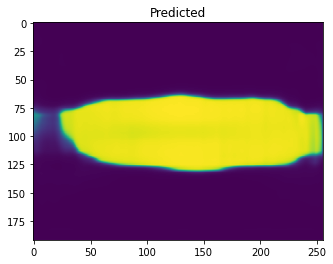

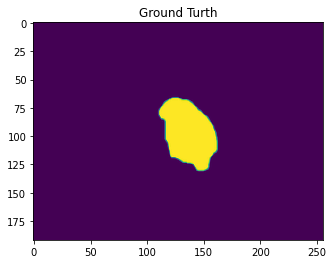

In [70]:
#index = 45
plt.figure()
plt.imshow(prediction)
plt.title('Predicted')
plt.figure()
plt.imshow(ground_truth)
plt.title('Ground Turth')

In [0]:
for i in range(len(x_train_full)):
  predictions =model.predict(x_train_full[i].reshape(1,192,256,3), batch_size=1)
  prediction = predictions.reshape(192, 256)
  plt.imsave('/content/drive/My Drive/results/dgu_results/' + str(i) + '_x.jpg', x_train_full[i])
  plt.imsave('/content/drive/My Drive/results/dgu_results/' + str(i) + '_y.jpg', y_train_full[i])
  plt.imsave('/content/drive/My Drive/results/dgu_results/' + str(i) + '.jpg', prediction)